In [ ]:
!nvidia-smi

Sun Feb 19 15:35:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    31W /  70W |   1904MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import os
import json

In [ ]:
import torch.nn as nn


In [ ]:
model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT, progress=True)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier =nn.Sequential(
                          nn.Dropout(p=0.3, inplace=True),
                          nn.Linear(in_features=1408, out_features=38, bias=True)
                              )
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import torchvision.datasets as datasets

In [ ]:
data_dir = '/content/drive/MyDrive/torch_ds/data/train'

In [ ]:
from torchvision import datasets, transforms

In [ ]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_images = datasets.ImageFolder(data_dir, transform=train_transform)


In [ ]:
train_images

Dataset ImageFolder
    Number of datapoints: 20696
    Root location: /content/drive/MyDrive/torch_ds/data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_images,
                                            batch_size=32, shuffle=True, drop_last=True, 
                                            num_workers=4)

In [ ]:
data_dir = '/content/drive/MyDrive/torch_ds/data/val'
transform  = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_images = datasets.ImageFolder(data_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_images,
                                          batch_size=32, shuffle=True, drop_last=True,
                                          num_workers=4)
val_loader


In [ ]:
data_dir = '/content/drive/MyDrive/torch_ds/data/test'
transform  = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_images = datasets.ImageFolder(data_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_images,
                                          batch_size=32, 
                                          num_workers=4, 
                                          shuffle=True,
                                          drop_last=True)
test_loader

In [ ]:
import time
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [ ]:
import numpy as np

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss + self.min_delta < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss >= self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
                
        return False

In [ ]:
import sys
from tqdm import tqdm

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, early_stopper, num_epochs=25, num_classes=1):
  
    since = time.perf_counter()

    val_acc_history = []
    val_loss_history = []

    lengths = {}
    for phase in ['train', 'val']:
        lengths[phase] = len(dataloaders[phase].dataset)
        print(f'{phase}_iters: {lengths[phase] // 32}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_start = time.perf_counter()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            lr = scheduler.optimizer.param_groups[0]['lr']
            running_loss = 0.0
            running_corrects = 0
            running_accuracy = 0.0

            with tqdm(dataloaders[phase], unit="batch", miniters=1) as tepoch:
                iter = 0
                for inputs, labels in tepoch:
                    iter += 1
                    if phase == 'train':
                        tepoch.set_description(f"Epoch {epoch + 1}")
                    else:
                        tepoch.set_description(f"Validation {epoch + 1}")

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels = labels.type(torch.int64)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(torch.softmax(outputs, 1), 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
                    running_accuracy = running_corrects / (iter * 32)
                    tepoch.set_postfix(loss=loss.item(), accuracy=running_accuracy.item())

                epoch_loss = running_loss / lengths[phase]
                epoch_acc = running_corrects.double() / lengths[phase]

                print(f'{phase}_loss: {epoch_loss:.4f} {phase}_acc: {epoch_acc:.4f}')

                if phase == 'val':
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        
                    if min_loss - epoch_loss >= early_stopper.min_delta:
                        min_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                        torch.save({'epoch': epoch, 
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'loss': epoch_loss}, '/content/drive/MyDrive/models/efnet_b2.tar')

                    scheduler.step(epoch_loss)
                    val_acc_history.append(epoch_acc)
                    val_loss_history.append(epoch_loss)
                    print(f"lr: {lr:.0E}  min_loss: {min_loss:.4f}")

        epoch_end = time.perf_counter()
        time_elapsed =  epoch_end - epoch_start

        print(f'Epoch {epoch + 1} took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if early_stopper.early_stop(epoch_loss):             
            break
        
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val_acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

In [ ]:
import torch.optim as optim

In [ ]:
for name, param in model.named_parameters():
      if param.requires_grad == True:
          print("\t",name)

	 classifier.1.weight
	 classifier.1.bias


In [ ]:
adam = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=0.1, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adam, patience=3, factor=0.1, threshold=1e-2, min_lr=1e-9)
criterion = nn.CrossEntropyLoss(label_smoothing=1e-2)
e_s = EarlyStopper(patience=10, min_delta=1e-2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [ ]:
train_images.class_to_idx

{'<NEG>': 0,
 'abyssinian': 1,
 'american_bulldog': 2,
 'american_pit_bull_terrier': 3,
 'basset_hound': 4,
 'beagle': 5,
 'bengal': 6,
 'birman': 7,
 'bombay': 8,
 'boxer': 9,
 'british_shorthair': 10,
 'chihuahua': 11,
 'egyptian_mau': 12,
 'english_cocker_spaniel': 13,
 'english_setter': 14,
 'german_shorthaired': 15,
 'great_pyrenees': 16,
 'havanese': 17,
 'japanese_chin': 18,
 'keeshond': 19,
 'leonberger': 20,
 'maine_coon': 21,
 'miniature_pinscher': 22,
 'newfoundland': 23,
 'persian': 24,
 'pomeranian': 25,
 'pug': 26,
 'ragdoll': 27,
 'russian_blue': 28,
 'saint_bernard': 29,
 'samoyed': 30,
 'scottish_terrier': 31,
 'shiba_inu': 32,
 'siamese': 33,
 'sphynx': 34,
 'staffordshire_bull_terrier': 35,
 'wheaten_terrier': 36,
 'yorkshire_terrier': 37}

In [ ]:
model = model.to(device)
model, val_acc_his, val_loss_his = train_model(model, dataloaders, criterion, adam, scheduler,
            e_s, num_classes=38, num_epochs=50)

train_iters: 646
val_iters: 50


Epoch 1: 100%|██████████| 646/646 [02:31<00:00,  4.27batch/s, accuracy=0.52, loss=1.58]


train_loss: 1.9678 train_acc: 0.5195


Validation 1: 100%|██████████| 50/50 [02:40<00:00,  3.21s/batch, accuracy=0.904, loss=0.481]


val_loss: 0.5195 val_acc: 0.9044
lr: 1E-03  min_loss: 0.5195
Epoch 1 took 5m 15s



Epoch 2: 100%|██████████| 646/646 [02:31<00:00,  4.27batch/s, accuracy=0.598, loss=2.01]


train_loss: 1.4987 train_acc: 0.5977


Validation 2: 100%|██████████| 50/50 [00:13<00:00,  3.72batch/s, accuracy=0.912, loss=0.499]


val_loss: 0.4433 val_acc: 0.9125
lr: 1E-03  min_loss: 0.4433
Epoch 2 took 2m 45s



Epoch 3: 100%|██████████| 646/646 [02:29<00:00,  4.33batch/s, accuracy=0.61, loss=1.68]


train_loss: 1.4408 train_acc: 0.6097


Validation 3: 100%|██████████| 50/50 [00:13<00:00,  3.75batch/s, accuracy=0.91, loss=0.482]


val_loss: 0.4274 val_acc: 0.9100
lr: 1E-03  min_loss: 0.4274
Epoch 3 took 2m 43s



Epoch 4: 100%|██████████| 646/646 [02:31<00:00,  4.27batch/s, accuracy=0.618, loss=1.3]


train_loss: 1.4158 train_acc: 0.6169


Validation 4: 100%|██████████| 50/50 [00:12<00:00,  3.98batch/s, accuracy=0.917, loss=0.503]


val_loss: 0.4121 val_acc: 0.9175
lr: 1E-03  min_loss: 0.4121
Epoch 4 took 2m 44s



Epoch 5: 100%|██████████| 646/646 [02:29<00:00,  4.32batch/s, accuracy=0.626, loss=1.68]


train_loss: 1.3790 train_acc: 0.6249


Validation 5: 100%|██████████| 50/50 [00:13<00:00,  3.76batch/s, accuracy=0.921, loss=0.348]


val_loss: 0.3985 val_acc: 0.9206
lr: 1E-03  min_loss: 0.3985
Epoch 5 took 2m 43s



Epoch 6: 100%|██████████| 646/646 [02:29<00:00,  4.33batch/s, accuracy=0.623, loss=1.38]


train_loss: 1.3789 train_acc: 0.6226


Validation 6: 100%|██████████| 50/50 [00:13<00:00,  3.74batch/s, accuracy=0.918, loss=0.298]


val_loss: 0.3921 val_acc: 0.9181
lr: 1E-03  min_loss: 0.3985
Epoch 6 took 2m 43s



Epoch 7: 100%|██████████| 646/646 [02:31<00:00,  4.26batch/s, accuracy=0.63, loss=1.17]


train_loss: 1.3685 train_acc: 0.6295


Validation 7: 100%|██████████| 50/50 [00:12<00:00,  3.96batch/s, accuracy=0.921, loss=0.431]


val_loss: 0.3850 val_acc: 0.9213
lr: 1E-03  min_loss: 0.3850
Epoch 7 took 2m 45s



Epoch 8: 100%|██████████| 646/646 [02:31<00:00,  4.26batch/s, accuracy=0.632, loss=1.61]


train_loss: 1.3688 train_acc: 0.6312


Validation 8: 100%|██████████| 50/50 [00:13<00:00,  3.76batch/s, accuracy=0.919, loss=0.372]


val_loss: 0.3960 val_acc: 0.9194
lr: 1E-03  min_loss: 0.3850
Epoch 8 took 2m 45s



Epoch 9: 100%|██████████| 646/646 [02:30<00:00,  4.30batch/s, accuracy=0.635, loss=1.62]


train_loss: 1.3554 train_acc: 0.6338


Validation 9: 100%|██████████| 50/50 [00:13<00:00,  3.74batch/s, accuracy=0.918, loss=0.427]


val_loss: 0.3950 val_acc: 0.9181
lr: 1E-03  min_loss: 0.3850
Epoch 9 took 2m 44s



Epoch 10: 100%|██████████| 646/646 [02:30<00:00,  4.29batch/s, accuracy=0.629, loss=1.21]


train_loss: 1.3591 train_acc: 0.6287


Validation 10: 100%|██████████| 50/50 [00:12<00:00,  4.00batch/s, accuracy=0.917, loss=0.338]


val_loss: 0.3959 val_acc: 0.9175
lr: 1E-03  min_loss: 0.3850
Epoch 10 took 2m 43s



Epoch 11: 100%|██████████| 646/646 [02:30<00:00,  4.28batch/s, accuracy=0.637, loss=1.44]


train_loss: 1.3469 train_acc: 0.6359


Validation 11: 100%|██████████| 50/50 [00:13<00:00,  3.80batch/s, accuracy=0.922, loss=0.407]


val_loss: 0.3968 val_acc: 0.9225
lr: 1E-03  min_loss: 0.3850
Epoch 11 took 2m 44s



Epoch 12: 100%|██████████| 646/646 [02:31<00:00,  4.27batch/s, accuracy=0.644, loss=1.26]


train_loss: 1.3232 train_acc: 0.6433


Validation 12: 100%|██████████| 50/50 [00:13<00:00,  3.72batch/s, accuracy=0.924, loss=0.455]


val_loss: 0.3818 val_acc: 0.9238
lr: 1E-04  min_loss: 0.3850
Epoch 12 took 2m 45s



Epoch 13: 100%|██████████| 646/646 [02:29<00:00,  4.31batch/s, accuracy=0.645, loss=1.13]


train_loss: 1.3168 train_acc: 0.6439


Validation 13: 100%|██████████| 50/50 [00:13<00:00,  3.76batch/s, accuracy=0.92, loss=0.391]


val_loss: 0.3877 val_acc: 0.9200
lr: 1E-04  min_loss: 0.3850
Epoch 13 took 2m 43s



Epoch 14: 100%|██████████| 646/646 [02:29<00:00,  4.31batch/s, accuracy=0.646, loss=1.31]


train_loss: 1.3152 train_acc: 0.6452


Validation 14: 100%|██████████| 50/50 [00:12<00:00,  4.04batch/s, accuracy=0.924, loss=0.25]


val_loss: 0.3852 val_acc: 0.9238
lr: 1E-04  min_loss: 0.3850
Epoch 14 took 2m 42s



Epoch 15: 100%|██████████| 646/646 [02:30<00:00,  4.29batch/s, accuracy=0.645, loss=1.15]


train_loss: 1.3101 train_acc: 0.6445


Validation 15: 100%|██████████| 50/50 [00:13<00:00,  3.77batch/s, accuracy=0.919, loss=0.309]


val_loss: 0.3850 val_acc: 0.9194
lr: 1E-04  min_loss: 0.3850
Epoch 15 took 2m 44s



Epoch 16: 100%|██████████| 646/646 [02:29<00:00,  4.33batch/s, accuracy=0.647, loss=1.17]


train_loss: 1.3137 train_acc: 0.6463


Validation 16: 100%|██████████| 50/50 [00:13<00:00,  3.77batch/s, accuracy=0.921, loss=0.27]


val_loss: 0.3821 val_acc: 0.9213
lr: 1E-05  min_loss: 0.3850
Epoch 16 took 2m 43s



Epoch 17: 100%|██████████| 646/646 [02:28<00:00,  4.35batch/s, accuracy=0.648, loss=1.43]


train_loss: 1.3076 train_acc: 0.6477


Validation 17: 100%|██████████| 50/50 [00:13<00:00,  3.76batch/s, accuracy=0.921, loss=0.372]


val_loss: 0.3851 val_acc: 0.9206
lr: 1E-05  min_loss: 0.3850
Epoch 17 took 2m 42s



Epoch 18: 100%|██████████| 646/646 [02:28<00:00,  4.35batch/s, accuracy=0.65, loss=1.32]


train_loss: 1.3067 train_acc: 0.6496


Validation 18: 100%|██████████| 50/50 [00:13<00:00,  3.75batch/s, accuracy=0.924, loss=0.419]


val_loss: 0.3851 val_acc: 0.9244
lr: 1E-05  min_loss: 0.3850
Epoch 18 took 2m 42s



Epoch 19: 100%|██████████| 646/646 [02:29<00:00,  4.31batch/s, accuracy=0.646, loss=1.58]


train_loss: 1.2998 train_acc: 0.6454


Validation 19: 100%|██████████| 50/50 [00:12<00:00,  4.04batch/s, accuracy=0.928, loss=0.328]


val_loss: 0.3846 val_acc: 0.9281
lr: 1E-05  min_loss: 0.3850
Epoch 19 took 2m 42s



Epoch 20: 100%|██████████| 646/646 [02:30<00:00,  4.28batch/s, accuracy=0.649, loss=1.96]


train_loss: 1.3040 train_acc: 0.6484


Validation 20: 100%|██████████| 50/50 [00:13<00:00,  3.73batch/s, accuracy=0.926, loss=0.387]


val_loss: 0.3826 val_acc: 0.9263
lr: 1E-06  min_loss: 0.3850
Epoch 20 took 2m 44s



Epoch 21: 100%|██████████| 646/646 [02:29<00:00,  4.32batch/s, accuracy=0.647, loss=1.19]


train_loss: 1.3024 train_acc: 0.6462


Validation 21: 100%|██████████| 50/50 [00:13<00:00,  3.74batch/s, accuracy=0.924, loss=0.414]


val_loss: 0.3893 val_acc: 0.9238
lr: 1E-06  min_loss: 0.3850
Epoch 21 took 2m 43s



Epoch 22: 100%|██████████| 646/646 [02:29<00:00,  4.33batch/s, accuracy=0.651, loss=1.15]


train_loss: 1.3031 train_acc: 0.6504


Validation 22: 100%|██████████| 50/50 [00:13<00:00,  3.74batch/s, accuracy=0.921, loss=0.391]


val_loss: 0.3878 val_acc: 0.9206
lr: 1E-06  min_loss: 0.3850
Epoch 22 took 2m 43s



Epoch 23: 100%|██████████| 646/646 [02:33<00:00,  4.21batch/s, accuracy=0.654, loss=1.26]


train_loss: 1.2987 train_acc: 0.6529


Validation 23: 100%|██████████| 50/50 [00:12<00:00,  3.93batch/s, accuracy=0.922, loss=0.25]


val_loss: 0.3919 val_acc: 0.9219
lr: 1E-06  min_loss: 0.3850
Epoch 23 took 2m 46s



Epoch 24: 100%|██████████| 646/646 [02:30<00:00,  4.28batch/s, accuracy=0.651, loss=1.68]


train_loss: 1.3014 train_acc: 0.6504


Validation 24: 100%|██████████| 50/50 [00:13<00:00,  3.73batch/s, accuracy=0.928, loss=0.218]


val_loss: 0.3820 val_acc: 0.9281
lr: 1E-07  min_loss: 0.3850
Epoch 24 took 2m 44s



Epoch 25: 100%|██████████| 646/646 [02:33<00:00,  4.20batch/s, accuracy=0.651, loss=1.24]


train_loss: 1.3013 train_acc: 0.6498


Validation 25: 100%|██████████| 50/50 [00:13<00:00,  3.68batch/s, accuracy=0.921, loss=0.458]


val_loss: 0.3858 val_acc: 0.9213
lr: 1E-07  min_loss: 0.3850
Epoch 25 took 2m 47s



Epoch 26: 100%|██████████| 646/646 [02:44<00:00,  3.93batch/s, accuracy=0.647, loss=1.71]


train_loss: 1.3029 train_acc: 0.6465


Validation 26: 100%|██████████| 50/50 [00:13<00:00,  3.77batch/s, accuracy=0.923, loss=0.454]


val_loss: 0.3881 val_acc: 0.9231
lr: 1E-07  min_loss: 0.3850
Epoch 26 took 2m 58s



Epoch 27: 100%|██████████| 646/646 [02:38<00:00,  4.07batch/s, accuracy=0.648, loss=1.15]


train_loss: 1.3051 train_acc: 0.6471


Validation 27: 100%|██████████| 50/50 [00:13<00:00,  3.70batch/s, accuracy=0.927, loss=0.379]


val_loss: 0.3833 val_acc: 0.9269
lr: 1E-07  min_loss: 0.3850
Epoch 27 took 2m 52s



Epoch 28: 100%|██████████| 646/646 [02:34<00:00,  4.18batch/s, accuracy=0.649, loss=1.73]


train_loss: 1.3069 train_acc: 0.6483


Validation 28: 100%|██████████| 50/50 [00:12<00:00,  4.01batch/s, accuracy=0.926, loss=0.522]


val_loss: 0.3871 val_acc: 0.9256
lr: 1E-08  min_loss: 0.3850
Epoch 28 took 2m 47s



Epoch 29: 100%|██████████| 646/646 [02:32<00:00,  4.23batch/s, accuracy=0.649, loss=1.72]


train_loss: 1.2994 train_acc: 0.6479


Validation 29: 100%|██████████| 50/50 [00:13<00:00,  3.74batch/s, accuracy=0.925, loss=0.221]


val_loss: 0.3849 val_acc: 0.9250
lr: 1E-08  min_loss: 0.3850
Epoch 29 took 2m 46s



Epoch 30: 100%|██████████| 646/646 [02:31<00:00,  4.26batch/s, accuracy=0.646, loss=1.6]


train_loss: 1.3072 train_acc: 0.6450


Validation 30: 100%|██████████| 50/50 [00:13<00:00,  3.74batch/s, accuracy=0.923, loss=0.481]


val_loss: 0.3862 val_acc: 0.9231
lr: 1E-08  min_loss: 0.3850
Epoch 30 took 2m 45s



Epoch 31: 100%|██████████| 646/646 [02:37<00:00,  4.10batch/s, accuracy=0.645, loss=1.18]


train_loss: 1.3139 train_acc: 0.6445


Validation 31: 100%|██████████| 50/50 [00:13<00:00,  3.61batch/s, accuracy=0.925, loss=0.346]


val_loss: 0.3774 val_acc: 0.9250
lr: 1E-08  min_loss: 0.3850
Epoch 31 took 2m 51s



Epoch 32: 100%|██████████| 646/646 [02:38<00:00,  4.06batch/s, accuracy=0.652, loss=1.08]


train_loss: 1.2977 train_acc: 0.6509


Validation 32: 100%|██████████| 50/50 [00:13<00:00,  3.63batch/s, accuracy=0.921, loss=0.413]


val_loss: 0.3879 val_acc: 0.9213
lr: 1E-08  min_loss: 0.3850
Epoch 32 took 2m 53s



Epoch 33: 100%|██████████| 646/646 [02:37<00:00,  4.11batch/s, accuracy=0.649, loss=1.07]


train_loss: 1.3070 train_acc: 0.6483


Validation 33: 100%|██████████| 50/50 [00:13<00:00,  3.66batch/s, accuracy=0.923, loss=0.38]


val_loss: 0.3827 val_acc: 0.9231
lr: 1E-08  min_loss: 0.3850
Epoch 33 took 2m 51s



Epoch 34: 100%|██████████| 646/646 [02:38<00:00,  4.06batch/s, accuracy=0.646, loss=1.27]


train_loss: 1.3112 train_acc: 0.6453


Validation 34: 100%|██████████| 50/50 [00:13<00:00,  3.63batch/s, accuracy=0.922, loss=0.258]


val_loss: 0.3813 val_acc: 0.9225
lr: 1E-08  min_loss: 0.3850
Epoch 34 took 2m 53s



Epoch 35: 100%|██████████| 646/646 [02:38<00:00,  4.07batch/s, accuracy=0.649, loss=0.896]


train_loss: 1.3057 train_acc: 0.6478


Validation 35: 100%|██████████| 50/50 [00:13<00:00,  3.69batch/s, accuracy=0.925, loss=0.387]


val_loss: 0.3784 val_acc: 0.9250
lr: 1E-08  min_loss: 0.3850
Epoch 35 took 2m 52s



Epoch 36: 100%|██████████| 646/646 [02:34<00:00,  4.17batch/s, accuracy=0.647, loss=1.32]


train_loss: 1.3008 train_acc: 0.6466


Validation 36: 100%|██████████| 50/50 [00:13<00:00,  3.68batch/s, accuracy=0.924, loss=0.287]


val_loss: 0.3845 val_acc: 0.9244
lr: 1E-08  min_loss: 0.3850
Epoch 36 took 2m 49s



Epoch 37: 100%|██████████| 646/646 [02:37<00:00,  4.10batch/s, accuracy=0.652, loss=1.55]


train_loss: 1.3016 train_acc: 0.6513


Validation 37: 100%|██████████| 50/50 [00:13<00:00,  3.69batch/s, accuracy=0.922, loss=0.432]


val_loss: 0.3868 val_acc: 0.9225
lr: 1E-08  min_loss: 0.3850
Epoch 37 took 2m 51s



Epoch 38: 100%|██████████| 646/646 [02:36<00:00,  4.12batch/s, accuracy=0.652, loss=1.52]


train_loss: 1.3054 train_acc: 0.6513


Validation 38: 100%|██████████| 50/50 [00:12<00:00,  3.97batch/s, accuracy=0.92, loss=0.239]


val_loss: 0.3877 val_acc: 0.9200
lr: 1E-08  min_loss: 0.3850
Epoch 38 took 2m 49s



Epoch 39: 100%|██████████| 646/646 [02:34<00:00,  4.17batch/s, accuracy=0.651, loss=1.22]


train_loss: 1.3000 train_acc: 0.6505


Validation 39: 100%|██████████| 50/50 [00:13<00:00,  3.70batch/s, accuracy=0.923, loss=0.246]


val_loss: 0.3828 val_acc: 0.9231
lr: 1E-08  min_loss: 0.3850
Epoch 39 took 2m 49s



Epoch 40: 100%|██████████| 646/646 [02:35<00:00,  4.14batch/s, accuracy=0.649, loss=1.3]


train_loss: 1.3075 train_acc: 0.6478


Validation 40: 100%|██████████| 50/50 [00:12<00:00,  3.94batch/s, accuracy=0.921, loss=0.427]


val_loss: 0.3804 val_acc: 0.9213
lr: 1E-08  min_loss: 0.3850
Epoch 40 took 2m 49s



Epoch 41: 100%|██████████| 646/646 [02:35<00:00,  4.15batch/s, accuracy=0.646, loss=1.58]


train_loss: 1.3021 train_acc: 0.6452


Validation 41: 100%|██████████| 50/50 [00:13<00:00,  3.67batch/s, accuracy=0.926, loss=0.551]


val_loss: 0.3835 val_acc: 0.9256
lr: 1E-08  min_loss: 0.3850
Epoch 41 took 2m 49s



Epoch 42: 100%|██████████| 646/646 [02:35<00:00,  4.15batch/s, accuracy=0.648, loss=1.88]


train_loss: 1.3117 train_acc: 0.6470


Validation 42: 100%|██████████| 50/50 [00:12<00:00,  3.96batch/s, accuracy=0.927, loss=0.372]


val_loss: 0.3818 val_acc: 0.9275
lr: 1E-08  min_loss: 0.3850
Epoch 42 took 2m 48s



Epoch 43: 100%|██████████| 646/646 [02:35<00:00,  4.15batch/s, accuracy=0.651, loss=1.08]


train_loss: 1.2979 train_acc: 0.6498


Validation 43: 100%|██████████| 50/50 [00:13<00:00,  3.69batch/s, accuracy=0.922, loss=0.289]


val_loss: 0.3873 val_acc: 0.9219
lr: 1E-08  min_loss: 0.3850
Epoch 43 took 2m 49s



Epoch 44: 100%|██████████| 646/646 [02:36<00:00,  4.13batch/s, accuracy=0.649, loss=1.32]


train_loss: 1.2970 train_acc: 0.6478


Validation 44: 100%|██████████| 50/50 [00:12<00:00,  3.85batch/s, accuracy=0.921, loss=0.271]


val_loss: 0.3847 val_acc: 0.9206
lr: 1E-08  min_loss: 0.3850
Epoch 44 took 2m 49s



Epoch 45: 100%|██████████| 646/646 [02:35<00:00,  4.15batch/s, accuracy=0.646, loss=1.3]


train_loss: 1.3113 train_acc: 0.6455


Validation 45: 100%|██████████| 50/50 [00:13<00:00,  3.67batch/s, accuracy=0.921, loss=0.362]


val_loss: 0.3821 val_acc: 0.9213
lr: 1E-08  min_loss: 0.3850
Epoch 45 took 2m 49s



Epoch 46: 100%|██████████| 646/646 [02:36<00:00,  4.12batch/s, accuracy=0.648, loss=1.67]


train_loss: 1.3064 train_acc: 0.6470


Validation 46: 100%|██████████| 50/50 [00:13<00:00,  3.81batch/s, accuracy=0.922, loss=0.482]


val_loss: 0.3891 val_acc: 0.9219
lr: 1E-08  min_loss: 0.3850
Epoch 46 took 2m 50s



Epoch 47: 100%|██████████| 646/646 [02:34<00:00,  4.18batch/s, accuracy=0.647, loss=1.56]


train_loss: 1.3069 train_acc: 0.6458


Validation 47: 100%|██████████| 50/50 [00:13<00:00,  3.69batch/s, accuracy=0.924, loss=0.364]


val_loss: 0.3801 val_acc: 0.9244
lr: 1E-08  min_loss: 0.3850
Epoch 47 took 2m 48s



Epoch 48: 100%|██████████| 646/646 [02:37<00:00,  4.11batch/s, accuracy=0.651, loss=1.29]


train_loss: 1.2923 train_acc: 0.6503


Validation 48: 100%|██████████| 50/50 [00:13<00:00,  3.70batch/s, accuracy=0.922, loss=0.302]


val_loss: 0.3914 val_acc: 0.9219
lr: 1E-08  min_loss: 0.3850
Epoch 48 took 2m 51s



Epoch 49: 100%|██████████| 646/646 [02:35<00:00,  4.16batch/s, accuracy=0.649, loss=1.75]


train_loss: 1.3122 train_acc: 0.6481


Validation 49: 100%|██████████| 50/50 [00:13<00:00,  3.66batch/s, accuracy=0.922, loss=0.456]


val_loss: 0.3879 val_acc: 0.9219
lr: 1E-08  min_loss: 0.3850
Epoch 49 took 2m 49s



Epoch 50: 100%|██████████| 646/646 [02:36<00:00,  4.12batch/s, accuracy=0.65, loss=1.37]


train_loss: 1.2992 train_acc: 0.6492


Validation 50: 100%|██████████| 50/50 [00:13<00:00,  3.72batch/s, accuracy=0.922, loss=0.274]


val_loss: 0.3881 val_acc: 0.9225
lr: 1E-08  min_loss: 0.3850
Epoch 50 took 2m 50s

Training complete in 141m 30s
Best val_acc: 0.928125


In [ ]:
breed_dict = train_images.class_to_idx
type(breed_dict)

dict

In [ ]:
breed_dict2 = {value: key.replace('_', ' ') for key, value in breed_dict.items()}
breed_dict2

{0: '<NEG>',
 1: 'abyssinian',
 2: 'american bulldog',
 3: 'american pit bull terrier',
 4: 'basset hound',
 5: 'beagle',
 6: 'bengal',
 7: 'birman',
 8: 'bombay',
 9: 'boxer',
 10: 'british shorthair',
 11: 'chihuahua',
 12: 'egyptian mau',
 13: 'english cocker spaniel',
 14: 'english setter',
 15: 'german shorthaired',
 16: 'great pyrenees',
 17: 'havanese',
 18: 'japanese chin',
 19: 'keeshond',
 20: 'leonberger',
 21: 'maine coon',
 22: 'miniature pinscher',
 23: 'newfoundland',
 24: 'persian',
 25: 'pomeranian',
 26: 'pug',
 27: 'ragdoll',
 28: 'russian blue',
 29: 'saint bernard',
 30: 'samoyed',
 31: 'scottish terrier',
 32: 'shiba inu',
 33: 'siamese',
 34: 'sphynx',
 35: 'staffordshire bull terrier',
 36: 'wheaten terrier',
 37: 'yorkshire terrier'}

In [ ]:
import json
with open('/content/drive/MyDrive/torch_ds/data/annotations/breed_dict.json', 'w') as f:
    json.dump(breed_dict2, f, indent=4)

In [ ]:
def test_model(model, test_dataloader, criterion):
    model.eval()

    since = time.perf_counter()

    running_loss = 0.0
    running_corrects = 0
    all_preds = np.array([])
    all_labels = np.array([])

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.int64)

        with torch.no_grad():  
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(torch.softmax(outputs, 1), 1)
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(torch.round(preds)==labels.data)

        labels = labels.to(torch.device('cpu'))
        preds = preds.to(torch.device('cpu'))

        labels_np = labels.detach().numpy()
        labels_np = np.reshape(labels_np, -1)
        all_labels = np.append(all_labels, labels_np, axis=0)

        preds_np = preds.detach().numpy()
        preds_np = np.reshape(preds_np, -1)
        all_preds = np.append(all_preds, preds_np, axis=0)

    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = running_corrects.double() / len(test_dataloader.dataset)

    print(f'test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}\n')

    print(f'Tested in {(time.perf_counter() - since):.1f}s')
    
    return all_preds, all_labels

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/models/efnet_b2.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
all_preds, all_labels = test_model(model, test_loader, nn.CrossEntropyLoss())

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

breed_dict = test_images.class_to_idx

test_loss: 0.3020 test_acc: 0.8937

Tested in 231.6s


                                 precision    recall  f1-score   support

                      (<NEG>) 0       0.97      0.96      0.97       107
                 (abyssinian) 1       0.86      0.94      0.90        32
           (american_bulldog) 2       0.81      0.86      0.83        29
  (american_pit_bull_terrier) 3       0.94      0.52      0.67        29
               (basset_hound) 4       0.91      0.97      0.94        30
                     (beagle) 5       0.96      0.87      0.91        30
                     (bengal) 6       0.85      0.79      0.82        29
                     (birman) 7       0.77      0.93      0.84        29
                     (bombay) 8       0.97      0.93      0.95        30
                      (boxer) 9       0.90      0.87      0.88        30
         (british_shorthair) 10       0.85      0.77      0.81        30
                 (chihuahua) 11       0.85      0.79      0.82        29
              (egyptian_mau) 12       0.86      0.

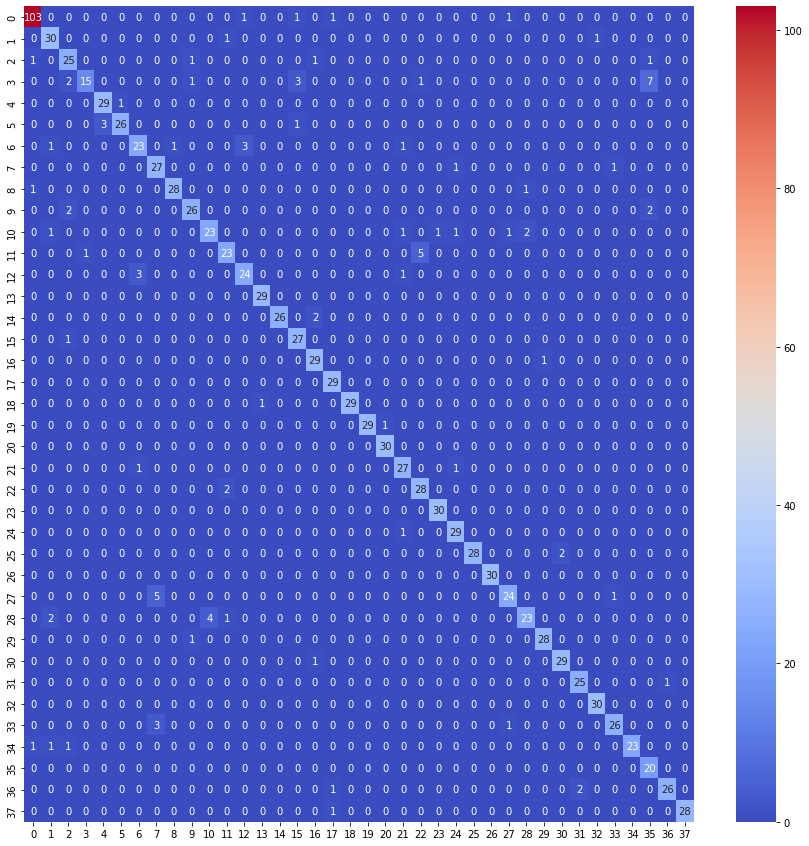

In [ ]:
targets = [f'({key}) {value}' for key, value in breed_dict.items()]

print(classification_report(all_labels, all_preds, target_names=targets))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


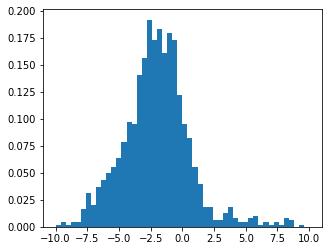

In [ ]:
inputs, _ = next(iter(test_loader))
inputs = inputs.to(device)

with torch.no_grad():  
  outputs = model(inputs)

outputs = outputs.view(-1, 1)
outputs = outputs.detach().cpu().numpy()


plt.figure(figsize=(5, 4))
plt.hist(outputs, 50, density=True, range=(-10, 10))
plt.show()